In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_squared_error

In [2]:
def quat_to_euler(quat):
    # Converts a quaternion matrix [w, x, y, z] into an Euler angle [roll, pitch, yaw] matrix
    euler = np.zeros(shape=(quat.shape[0], 3))
    for i in range(quat.shape[0]):
        qw, qx, qy, qz = quat[i, :]
        roll = np.arctan2(2*(qw*qx+qy*qz), 1-2*(qx**2+qy**2))
        pitch = -np.pi/2 + 2*np.arctan2(np.sqrt(1+2*(qw*qy-qx*qz)), np.sqrt(1-2*(qw*qy-qx*qz)))
        yaw = np.arctan2(2*(qw*qz+qx*qy), 1-2*(qy**2+qz**2))
        euler[i,:] = [roll, pitch, yaw]
    return euler

In [3]:
f = h5py.File('data/drone_sim/sunny.hdf5')
train_set = ['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009',
             '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019']
test_set = ['0020', '0021', '0022', '0023', '0024', '0025']

MODEL_DELAY = 5

# Construct training data set
Y_train = np.zeros(shape=(0,3))
X_train = np.zeros(shape=(0,9*MODEL_DELAY))
for i, traj_num in enumerate(train_set):
    # Get traj
    traj_name = f"trajectory_{traj_num}"
    traj = f[traj_name]
    # GPS
    gps_pos = traj['gps']['position']
    # gps_vel = traj['gps']['velocity']
    # Ground truth
    gnd_pos = traj['groundtruth']['position']
    # gnd_vel = traj['groundtruth']['velocity']
    gnd_att = quat_to_euler(traj['groundtruth']['attitude'])
    # IMU unit
    imu_acc = traj['imu']['accelerometer']
    imu_gyr = traj['imu']['gyroscope']

    # Get IMU average per GPS update
    imu_sumdiv = int(np.floor(imu_acc.shape[0]/100))
    avg_acc = np.zeros(shape=(imu_sumdiv+1,3))
    avg_acc[0,:] = imu_acc[0,:]
    avg_gyr = np.zeros(shape=(imu_sumdiv+1,3))
    avg_gyr[0,:] = imu_gyr[0,:]

    for i in range(imu_sumdiv):
        avg_acc[i+1,:] = np.average(imu_acc[1+100*i:1+100*(i+1),:], axis=0)
        avg_gyr[i+1,:] = np.average(imu_gyr[1+100*i:1+100*(i+1),:], axis=0)
    avg_acc = avg_acc - [0, 0, -9.81]

    # Construct training set
    dp_ = gps_pos.shape[0]-MODEL_DELAY
    Y_train_ = np.zeros(shape=(dp_, 3))
    X_train_ = np.zeros(shape=(dp_, 9*MODEL_DELAY))
    for i in range(dp_):
        Y_ = gps_pos[i+MODEL_DELAY,:] - gps_pos[i+MODEL_DELAY-1,:]
        Y_train_[i,:] = Y_
        X_ = np.hstack((avg_acc[i:i+MODEL_DELAY,:].flatten(),
                        avg_gyr[i:i+MODEL_DELAY,:].flatten(),
                        gnd_att[i*100:(i+MODEL_DELAY)*100:100,:].flatten()))
        X_train_[i,:] = X_
    
    # Add to X and Y sets
    X_train = np.vstack((X_train, X_train_))
    Y_train = np.vstack((Y_train, Y_train_))

# Construct testing data set
Y_test_list = []
X_test_list = []
for i, traj_num in enumerate(test_set):
    # Get traj
    traj_name = f"trajectory_{traj_num}"
    traj = f[traj_name]
    # GPS
    gps_pos = traj['gps']['position']
    # gps_vel = traj['gps']['velocity']
    # Ground truth
    gnd_pos = traj['groundtruth']['position']
    # gnd_vel = traj['groundtruth']['velocity']
    gnd_att = quat_to_euler(traj['groundtruth']['attitude'])
    # IMU unit
    imu_acc = traj['imu']['accelerometer']
    imu_gyr = traj['imu']['gyroscope']

    # Get IMU average per GPS update
    imu_sumdiv = int(np.floor(imu_acc.shape[0]/100))
    avg_acc = np.zeros(shape=(imu_sumdiv+1,3))
    avg_acc[0,:] = imu_acc[0,:]
    avg_gyr = np.zeros(shape=(imu_sumdiv+1,3))
    avg_gyr[0,:] = imu_gyr[0,:]

    for i in range(imu_sumdiv):
        avg_acc[i+1,:] = np.average(imu_acc[1+100*i:1+100*(i+1),:], axis=0)
        avg_gyr[i+1,:] = np.average(imu_gyr[1+100*i:1+100*(i+1),:], axis=0)
    avg_acc = avg_acc - [0, 0, -9.81]

    # Construct training set
    dp_ = gps_pos.shape[0]-MODEL_DELAY
    Y_test = np.zeros(shape=(dp_, 3))
    X_test = np.zeros(shape=(dp_, 9*MODEL_DELAY))
    for i in range(dp_):
        Y_ = gps_pos[i+MODEL_DELAY,:] - gps_pos[i+MODEL_DELAY-1,:]
        Y_test[i,:] = Y_
        X_ = np.hstack((avg_acc[i:i+MODEL_DELAY,:].flatten(),
                        avg_gyr[i:i+MODEL_DELAY,:].flatten(),
                        gnd_att[i*100:(i+MODEL_DELAY)*100:100,:].flatten()))
        X_test[i,:] = X_
    
    # Add to X and Y sets
    X_test_list.append(X_test)
    Y_test_list.append(Y_test)

In [4]:
# Train LS model
BETA_REG = 1
w_x = np.linalg.inv(X_train.T @ X_train + BETA_REG*np.eye(X_train.shape[1])) @ X_train.T @ Y_train[:,0]
w_y = np.linalg.inv(X_train.T @ X_train + BETA_REG*np.eye(X_train.shape[1])) @ X_train.T @ Y_train[:,1]
w_z = np.linalg.inv(X_train.T @ X_train + BETA_REG*np.eye(X_train.shape[1])) @ X_train.T @ Y_train[:,2]
Y_pred_train_x = X_train @ w_x
Y_pred_train_y = X_train @ w_y
Y_pred_train_z = X_train @ w_z

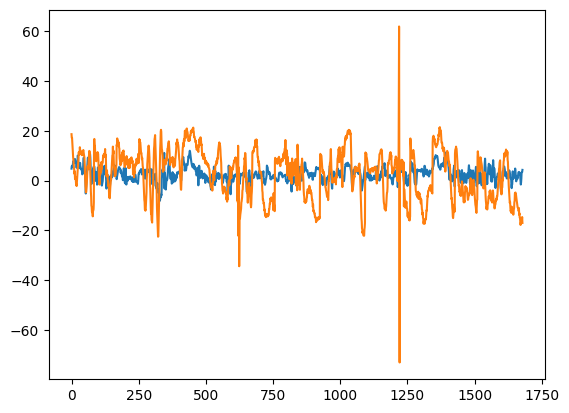

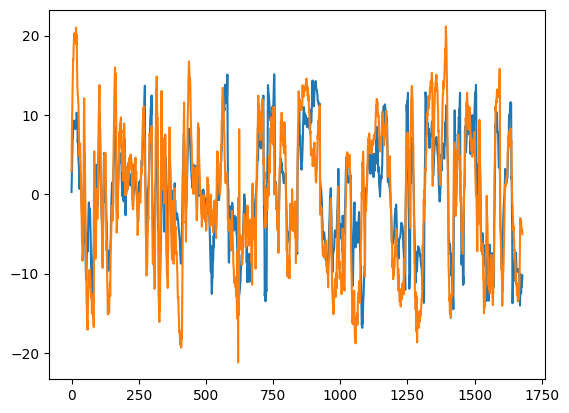

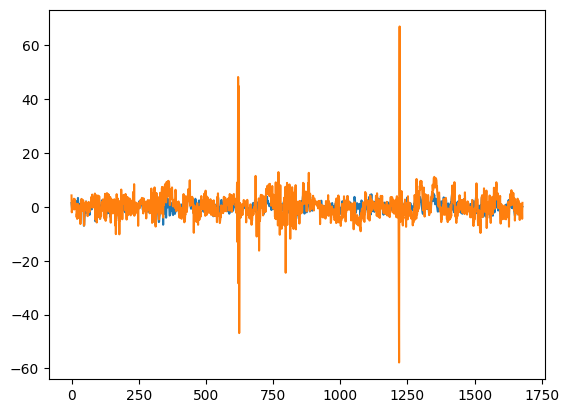

In [5]:
plt.figure()
plt.plot(Y_pred_train_x)
plt.plot(Y_train[:,0])
plt.figure()
plt.plot(Y_pred_train_y)
plt.plot(Y_train[:,1])
plt.figure()
plt.plot(Y_pred_train_z)
plt.plot(Y_train[:,2])
plt.show()

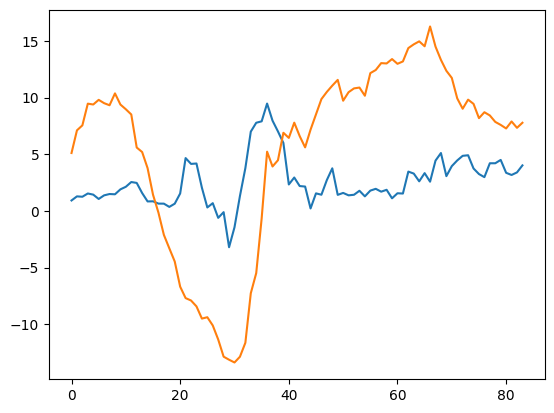

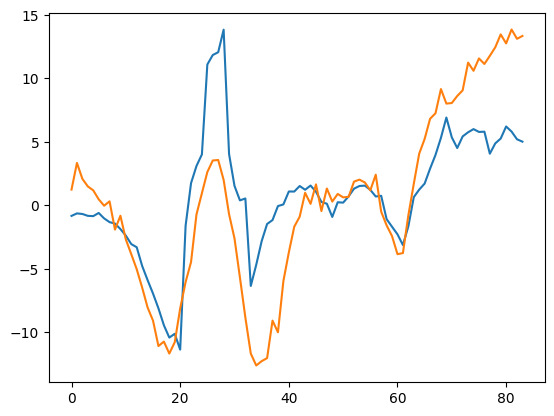

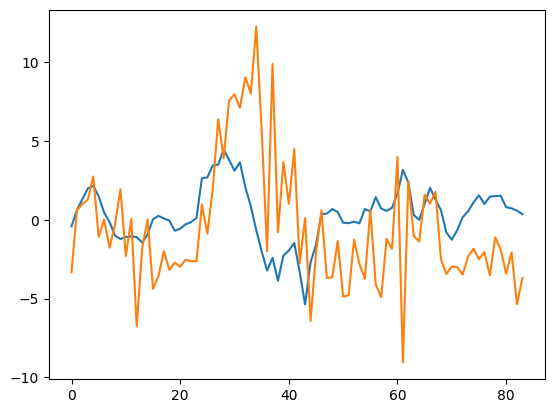

In [6]:
test_index = 1

Y_test = Y_test_list[test_index]
X_test = X_test_list[test_index]

Y_pred_test_x = X_test @ w_x
Y_pred_test_y = X_test @ w_y
Y_pred_test_z = X_test @ w_z

plt.figure()
plt.plot(Y_pred_test_x)
plt.plot(Y_test[:,0])
plt.figure()
plt.plot(Y_pred_test_y)
plt.plot(Y_test[:,1])
plt.figure()
plt.plot(Y_pred_test_z)
plt.plot(Y_test[:,2])
plt.show()

In [7]:
X_train_tensor = torch.from_numpy(X_train).to(torch.float32)
Y_train_tensor = torch.from_numpy(Y_train).to(torch.float32)
X_test_tensor  = torch.from_numpy(X_test_list[0]).to(torch.float32)
Y_test_tensor  = torch.from_numpy(Y_test_list[0]).to(torch.float32)

dp, features = X_train_tensor.shape
_, outputs = Y_train_tensor.shape

NUM_HIDDEN_LAYERS = 16
LEARNING_RATE = 1e-2
MOMENTUM = 0.9
NUM_EPOCHS = 10000

# Define model, loss function, and search algorithm
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=features, out_features=NUM_HIDDEN_LAYERS),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=NUM_HIDDEN_LAYERS, out_features=outputs)
)
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Train model
model.train()
for epoch in range(1, NUM_EPOCHS+1):
    Y_pred_ = model(X_train_tensor)
    loss_value = loss(Y_pred_, Y_train_tensor)

    model.zero_grad()
    loss_value.backward()
    optimizer.step()
    if (epoch == 1) or ((epoch % 100) == 0):
        print(f"Epoch {epoch}, training loss: {loss_value.item():.4f}")

# Evaluate train set
model.eval()
with torch.no_grad():
    Y_pred_train_nn = model(X_train_tensor).numpy()
    Y_pred_test_nn = model(X_test_tensor).numpy()

Epoch 1, training loss: 66.2534
Epoch 100, training loss: 14.8438
Epoch 200, training loss: 12.4048
Epoch 300, training loss: 11.6296
Epoch 400, training loss: 11.2407
Epoch 500, training loss: 11.0050
Epoch 600, training loss: 10.8462
Epoch 700, training loss: 10.7259
Epoch 800, training loss: 10.6368
Epoch 900, training loss: 10.5682
Epoch 1000, training loss: 10.5156
Epoch 1100, training loss: 10.4613
Epoch 1200, training loss: 10.4170
Epoch 1300, training loss: 10.3802
Epoch 1400, training loss: 10.3472
Epoch 1500, training loss: 10.3087
Epoch 1600, training loss: 10.2735
Epoch 1700, training loss: 10.2459
Epoch 1800, training loss: 10.2168
Epoch 1900, training loss: 10.2023
Epoch 2000, training loss: 10.1904
Epoch 2100, training loss: 10.1538
Epoch 2200, training loss: 10.1696
Epoch 2300, training loss: 10.1488
Epoch 2400, training loss: 10.1680
Epoch 2500, training loss: 10.2111
Epoch 2600, training loss: 10.0766
Epoch 2700, training loss: 10.0269
Epoch 2800, training loss: 10.09

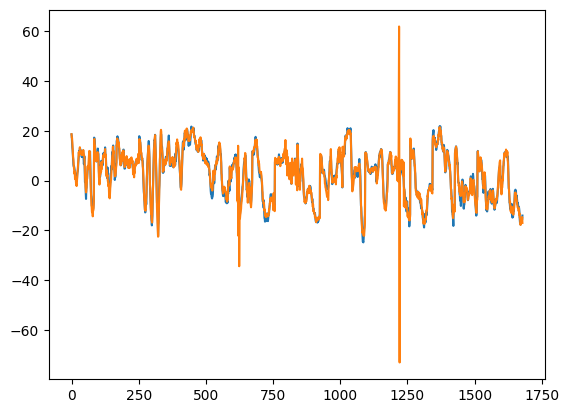

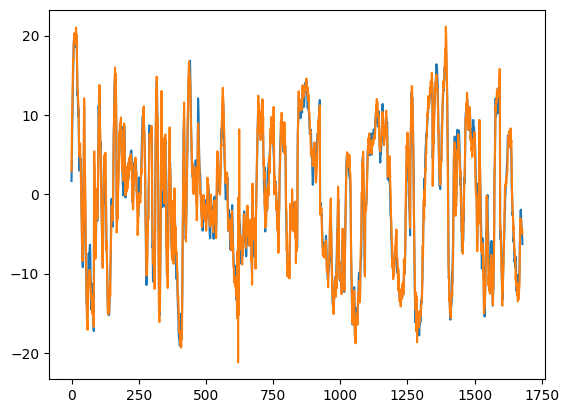

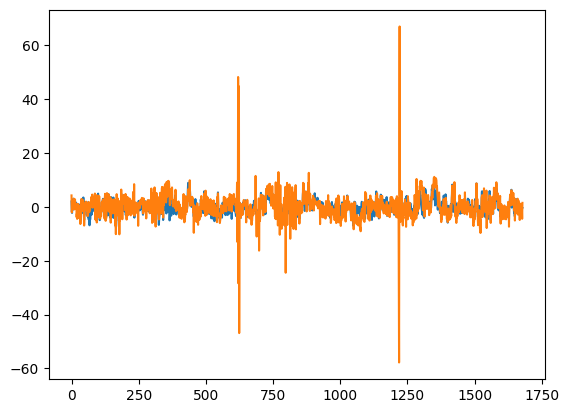

In [8]:
plt.figure()
plt.plot(Y_pred_train_nn[:,0])
plt.plot(Y_train[:,0])
plt.figure()
plt.plot(Y_pred_train_nn[:,1])
plt.plot(Y_train[:,1])
plt.figure()
plt.plot(Y_pred_train_nn[:,2])
plt.plot(Y_train[:,2])
plt.show()

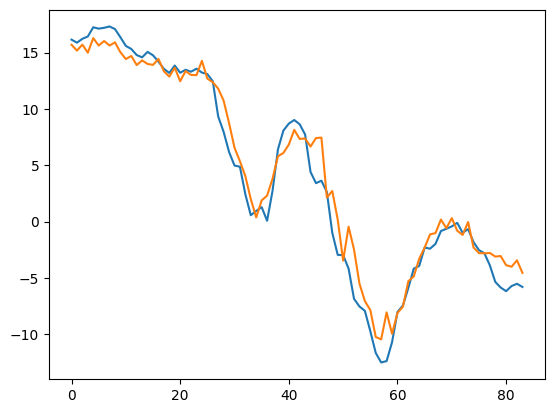

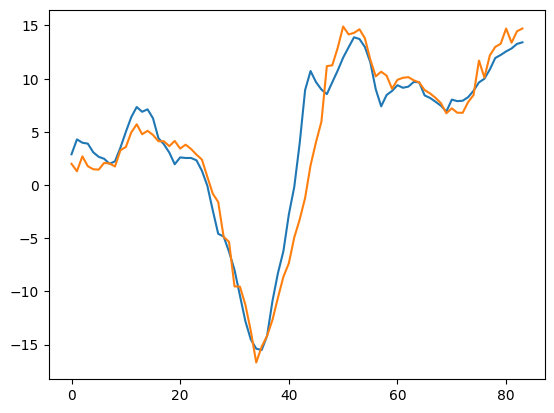

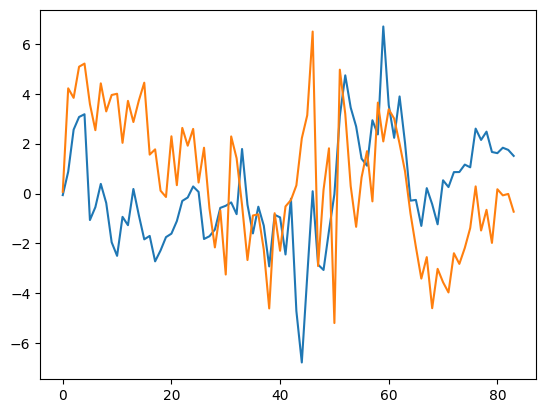

In [9]:
plt.figure()
plt.plot(Y_pred_test_nn[:,0])
plt.plot(Y_test_list[0][:,0])
plt.figure()
plt.plot(Y_pred_test_nn[:,1])
plt.plot(Y_test_list[0][:,1])
plt.figure()
plt.plot(Y_pred_test_nn[:,2])
plt.plot(Y_test_list[0][:,2])
plt.show()

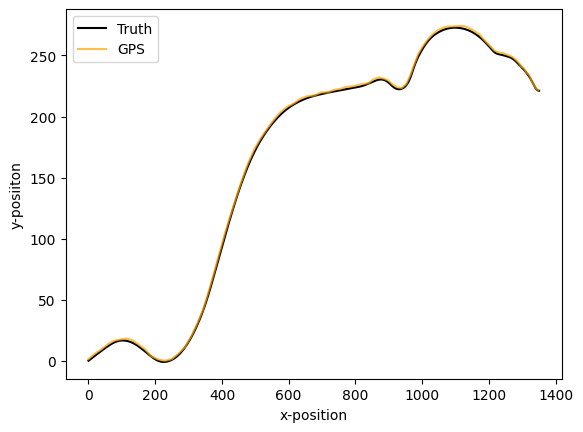

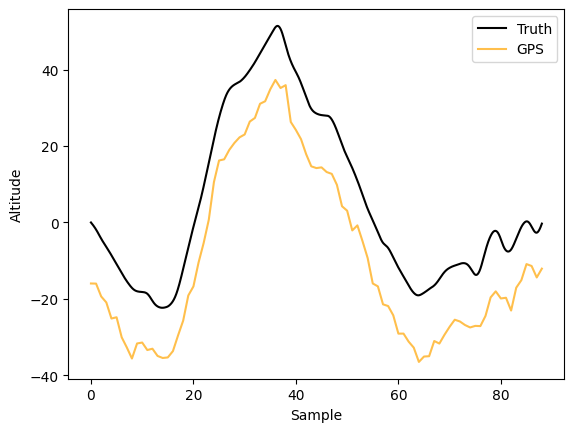

In [4]:
plt.figure()
plt.plot(gnd_pos[:,0], gnd_pos[:,1], c='black', label="Truth")
plt.plot(gps_pos[:,0], gps_pos[:,1], c="orange", alpha=0.7, label="GPS")
plt.xlabel("x-position")
plt.ylabel("y-posiiton")
plt.legend()

plt.figure()
final_time_ = gps_pos.shape[0]-1
t_gnd_ = np.linspace(0, final_time_, gnd_pos.shape[0])
t_gps_ = np.linspace(0, final_time_, gps_pos.shape[0])
plt.plot(t_gnd_, gnd_pos[:,2], c='black', label="Truth")
plt.plot(t_gps_, gps_pos[:,2], c="orange", alpha=0.7, label="GPS")
plt.xlabel("Sample")
plt.ylabel("Altitude")
plt.legend()

In [4]:
gnd_att_euler = np.zeros(shape=(gnd_att.shape[0],3))
for i in range(gnd_att.shape[0]):
    qw, qx, qy, qz = gnd_att[i, :]
    roll = np.arctan2(2*(qw*qx+qy*qz), 1-2*(qx**2+qy**2))
    pitch = -np.pi/2 + 2*np.arctan2(np.sqrt(1+2*(qw*qy-qx*qz)), np.sqrt(1-2*(qw*qy-qx*qz)))
    yaw = np.arctan2(2*(qw*qz+qx*qy), 1-2*(qy**2+qz**2))
    gnd_att_euler[i,:] = [roll, pitch, yaw]


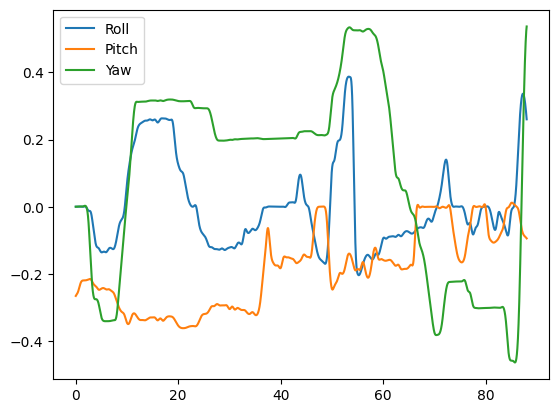

In [6]:
t_imu_ = np.linspace(0, np.floor(gnd_att_euler.shape[0]/100), gnd_att_euler.shape[0])
plt.plot(t_imu_, gnd_att_euler[:,0], label="Roll")
plt.plot(t_imu_, gnd_att_euler[:,1], label="Pitch")
plt.plot(t_imu_, gnd_att_euler[:,2], label="Yaw")
plt.legend()
plt.show()

In [10]:
att_estim_gyr = np.zeros(shape=(imu_gyr.shape[0], 3))
att_estim_gyr[0,:] = gnd_att_euler[0,:]
dt = 1/100
for i in range(1, imu_gyr.shape[0]):
    roll_   = att_estim_gyr[i-1,0] + imu_gyr[i-1,0]*dt
    pitch_  = att_estim_gyr[i-1,1] + imu_gyr[i-1,1]*dt
    yaw_    = att_estim_gyr[i-1,2] + imu_gyr[i-1,2]*dt
    att_estim_gyr[i,:] = [roll_, pitch_, yaw_]

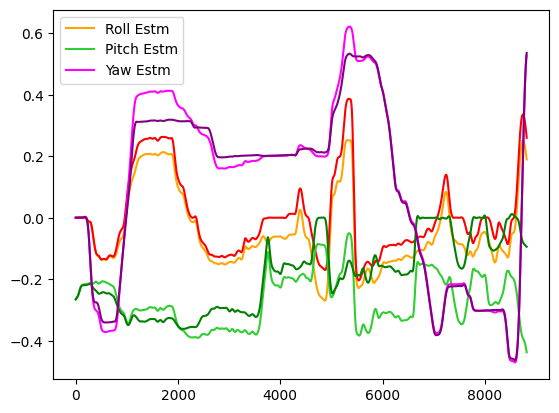

In [16]:
t_imu_ = np.linspace(0, np.floor(gnd_att_euler.shape[0]/100), gnd_att_euler.shape[0])
plt.plot(att_estim_gyr[:,0], c="orange", label="Roll Estm")
plt.plot(gnd_att_euler[:,0], c="red")
plt.plot(att_estim_gyr[:,1], c="limegreen", label="Pitch Estm")
plt.plot(gnd_att_euler[:,1], c="green")
plt.plot(att_estim_gyr[:,2], c="magenta", label="Yaw Estm")
plt.plot(gnd_att_euler[:,2], c="purple")
plt.legend()
plt.show()

In [22]:
imu_sumdiv = int(np.floor(imu_acc.shape[0]/100))

avg_acc = np.zeros(shape=(imu_sumdiv+1,3))
avg_acc[0,:] = imu_acc[0,:]
avg_gyr = np.zeros(shape=(imu_sumdiv+1,3))
avg_gyr[0,:] = imu_gyr[0,:]

for i in range(imu_sumdiv):
    avg_acc[i+1,:] = np.average(imu_acc[1+100*i:1+100*(i+1),:], axis=0)
    avg_gyr[i+1,:] = np.average(imu_gyr[1+100*i:1+100*(i+1),:], axis=0)
avg_acc = avg_acc - [0, 0, -9.81]

In [47]:
# Construct training set
dp_ = gps_pos.shape[0]-1
Y_train = np.zeros(shape=(dp_, 3))
X_train = np.zeros(shape=(dp_, 12))
for i in range(dp_):
    Y_ = gps_pos[i+1,:] - gps_pos[i,:]
    Y_train[i,:] = Y_
    X_ = np.hstack((avg_acc[i,:], avg_gyr[i,:], gnd_att_euler[i*100,:], gps_vel[i,:]))
    # X_ = np.hstack((avg_acc[i,:]))
    X_train[i,:] = X_

In [48]:
# y = H @ theta
BETA_REG = 1
w_x = np.linalg.inv(X_train.T @ X_train + BETA_REG*np.eye(X_train.shape[1])) @ X_train.T @ Y_train[:,0]
w_y = np.linalg.inv(X_train.T @ X_train + BETA_REG*np.eye(X_train.shape[1])) @ X_train.T @ Y_train[:,1]
w_z = np.linalg.inv(X_train.T @ X_train + BETA_REG*np.eye(X_train.shape[1])) @ X_train.T @ Y_train[:,2]
Y_pred_x = X_train @ w_x
Y_pred_y = X_train @ w_y
Y_pred_z = X_train @ w_z

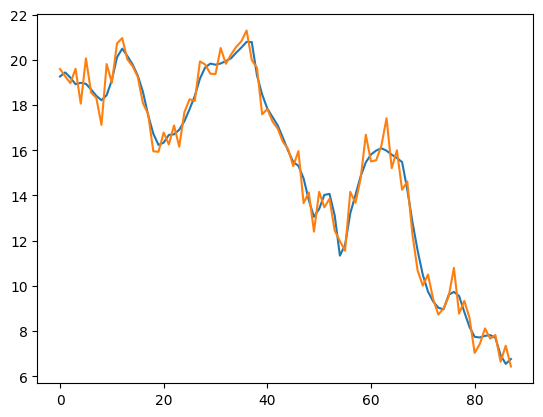

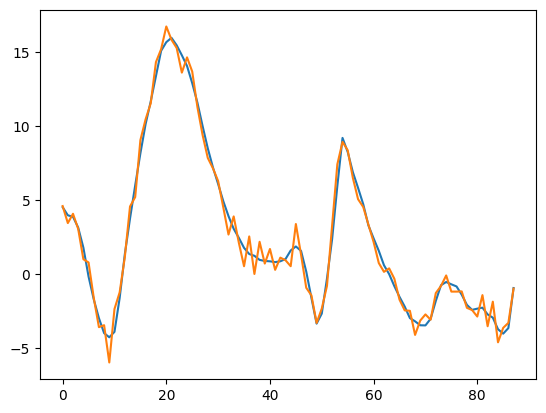

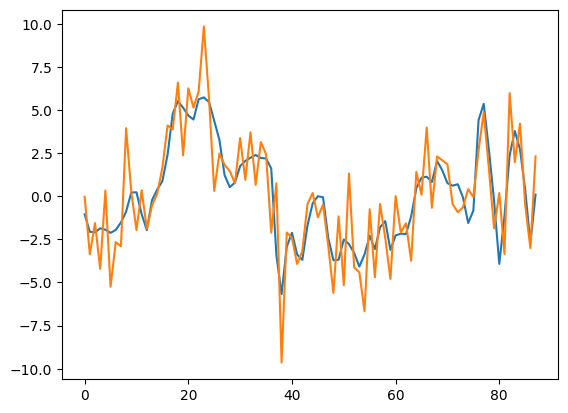

In [49]:
plt.figure()
plt.plot(Y_pred_x)
plt.plot(Y_train[:,0])
plt.figure()
plt.plot(Y_pred_y)
plt.plot(Y_train[:,1])
plt.figure()
plt.plot(Y_pred_z)
plt.plot(Y_train[:,2])
plt.show()